In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pickle

In [ ]:
matches=pd.read_csv('matches.csv')

In [ ]:
null_columns=matches.isnull().sum()
print(null_columns[null_columns > 0])

city                 7
winner               4
player_of_match      4
umpire1              2
umpire2              2
umpire3            637
dtype: int64


In [ ]:
conditions = [matches["venue"] == "Rajiv Gandhi International Stadium, Uppal",matches["venue"] == "Maharashtra Cricket Association Stadium",
              matches["venue"] == "Saurashtra Cricket Association Stadium", matches["venue"] == "Holkar Cricket Stadium",
              matches["venue"] == "M Chinnaswamy Stadium",matches["venue"] == "Wankhede Stadium",
              matches["venue"] == "Eden Gardens",matches["venue"] == "Feroz Shah Kotla",
              matches["venue"] == "Punjab Cricket Association IS Bindra Stadium, Mohali",matches["venue"] == "Green Park",
              matches["venue"] == "Punjab Cricket Association Stadium, Mohali",matches["venue"] == "Dr DY Patil Sports Academy",
              matches["venue"] == "Sawai Mansingh Stadium", matches["venue"] == "MA Chidambaram Stadium, Chepauk", 
              matches["venue"] == "Newlands", matches["venue"] == "St George's Park" , 
              matches["venue"] == "Kingsmead", matches["venue"] == "SuperSport Park",
              matches["venue"] == "Buffalo Park", matches["venue"] == "New Wanderers Stadium",
              matches["venue"] == "De Beers Diamond Oval", matches["venue"] == "OUTsurance Oval", 
              matches["venue"] == "Brabourne Stadium",matches["venue"] == "Sardar Patel Stadium", 
              matches["venue"] == "Barabati Stadium", matches["venue"] == "Vidarbha Cricket Association Stadium, Jamtha",
              matches["venue"] == "Himachal Pradesh Cricket Association Stadium",matches["venue"] == "Nehru Stadium",
              matches["venue"] == "Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium",matches["venue"] == "Subrata Roy Sahara Stadium",
              matches["venue"] == "Shaheed Veer Narayan Singh International Stadium",matches["venue"] == "JSCA International Stadium Complex",
              matches["venue"] == "Sheikh Zayed Stadium",matches["venue"] == "Sharjah Cricket Stadium",
              matches["venue"] == "Dubai International Cricket Stadium",matches["venue"] == "M. A. Chidambaram Stadium",
              matches["venue"] == "Feroz Shah Kotla Ground",matches["venue"] == "M. Chinnaswamy Stadium",
              matches["venue"] == "Rajiv Gandhi Intl. Cricket Stadium" ,matches["venue"] == "IS Bindra Stadium",matches["venue"] == "ACA-VDCA Stadium"]
values = ['Hyderabad', 'Mumbai', 'Rajkot',"Indore","Bengaluru","Mumbai","Kolkata","Delhi","Mohali","Kanpur","Mohali","Pune","Jaipur","Chennai","Cape Town","Port Elizabeth","Durban",
          "Centurion",'Eastern Cape','Johannesburg','Northern Cape','Bloemfontein','Mumbai','Ahmedabad','Cuttack','Jamtha','Dharamshala','Chennai','Visakhapatnam','Pune','Raipur','Ranchi',
          'Abu Dhabi','Sharjah','Dubai','Chennai','Delhi','Bengaluru','Hyderabad','Mohali','Visakhapatnam']
matches['city'] = np.where(matches['city'].isnull(),
                              np.select(conditions, values),
                              matches['city'])

In [ ]:
null_columns=matches.isnull().sum()
print(null_columns[null_columns > 0])

#Removing records having null values in "winner" column
matches=matches[matches["winner"].notna()]
matches


winner               4
player_of_match      4
umpire1              2
umpire2              2
umpire3            637
dtype: int64


,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,2019,Mumbai,05/05/19,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan,S Ravi
752,11412,2019,Chennai,07/05/19,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon,Ian Gould
753,11413,2019,Visakhapatnam,08/05/19,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,NaN,NaN,NaN
754,11414,2019,Visakhapatnam,10/05/19,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin


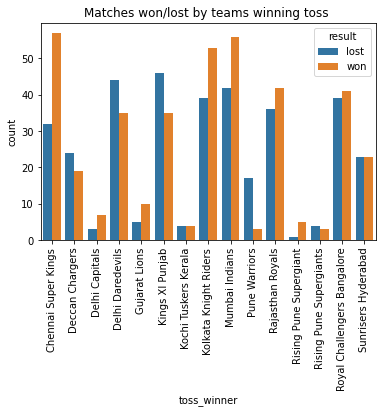

In [ ]:
toss_win_result = matches.groupby(['toss_winner']).winner.value_counts().reset_index(name="count")
toss_win_result['result']=np.where(toss_win_result.winner==toss_win_result.toss_winner,'won','lost')
toss_win_result_df = toss_win_result.groupby(['toss_winner','result'])['count'].sum().reset_index()
#Visualization
plot = sns.barplot(x="toss_winner", y="count", hue="result", data=toss_win_result_df)
plot.set_title('Matches won/lost by teams winning toss ')
plot.set_xticklabels(toss_win_result_df['toss_winner'].unique(),rotation=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


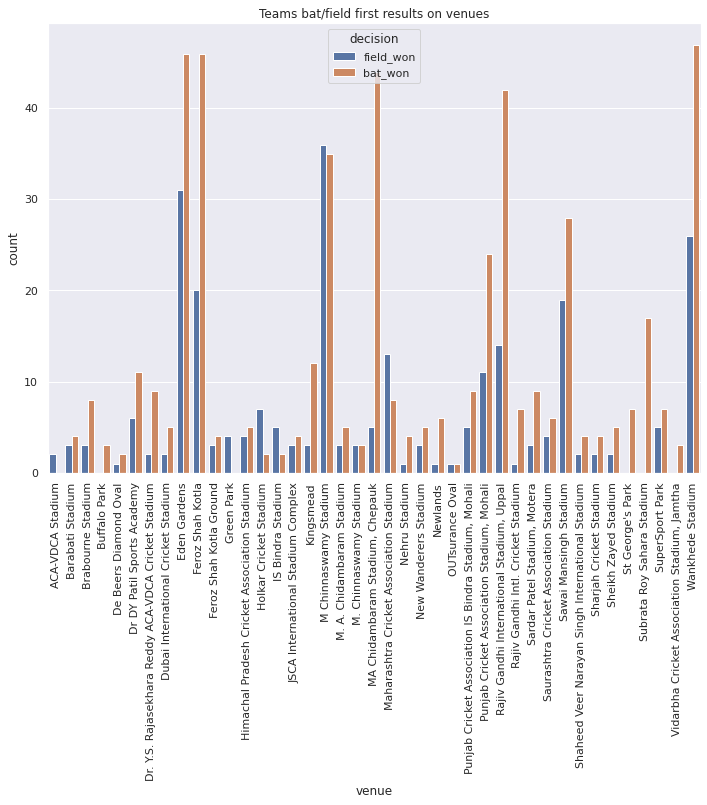

In [ ]:
venue_toss_decision_result=matches[["toss_winner","toss_decision","winner","venue"]]
venue_toss_decision_result["decision"]=np.where((venue_toss_decision_result.toss_winner == venue_toss_decision_result.winner) & (venue_toss_decision_result.toss_decision=="field"),"field_won","bat_won")
venue_result=venue_toss_decision_result.groupby(["venue"]).decision.value_counts().reset_index(name="count")
#Visualization
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.barplot(x="venue", y="count", hue="decision", data=venue_result)
plot.set_title('Teams bat/field first results on venues')
plot.set_xticklabels(venue_result['venue'].unique(),rotation=90)
plt.show()

Text(0.5, 1.0, 'No of matches won by different teams')

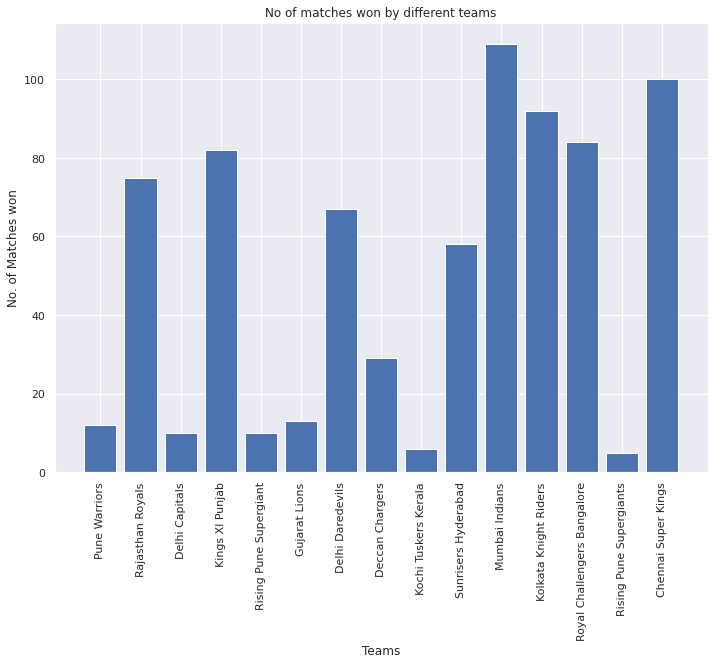

In [ ]:
teams = list(set(matches.loc[:,'team1']))
matches_won = [len(matches.loc[matches['winner'] == i]) for i in teams]
plt.bar(np.arange(len(teams)), matches_won)
plt.xticks(np.arange(len(teams)), teams, rotation='vertical')
plt.ylabel('No. of Matches won')
plt.xlabel('Teams')
plt.title('No of matches won by different teams')


In [ ]:
matches["team2"]=matches["team2"].replace("Rising Pune Supergiant","Rising Pune Supergiants")
matches["team1"]=matches["team1"].replace("Rising Pune Supergiant","Rising Pune Supergiants")
matches["winner"]=matches["winner"].replace("Rising Pune Supergiant","Rising Pune Supergiants")
matches["toss_winner"]=matches["toss_winner"].replace("Rising Pune Supergiant","Rising Pune Supergiants")


In [ ]:
encoder= LabelEncoder()
matches["team1"]=encoder.fit_transform(matches["team1"])
matches["team2"]=encoder.fit_transform(matches["team2"])
matches["winner"]=encoder.fit_transform(matches["winner"].astype(str))
matches["toss_winner"]=encoder.fit_transform(matches["toss_winner"])
matches["venue"]=encoder.fit_transform(matches["venue"])

#outcome variable as a probability of team1 winning
matches.loc[matches["winner"]==matches["team1"],"team1_win"]=1
matches.loc[matches["winner"]!=matches["team1"],"team1_win"]=0

matches.loc[matches["toss_winner"]==matches["team1"],"team1_toss_win"]=1
matches.loc[matches["toss_winner"]!=matches["team1"],"team1_toss_win"]=0

matches["team1_bat"]=0
matches.loc[(matches["team1_toss_win"]==1) & (matches["toss_decision"]=="bat"),"team1_bat"]=1

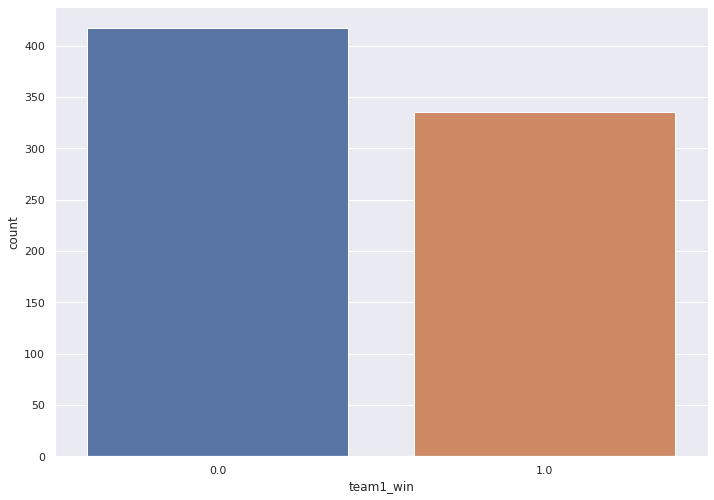

In [ ]:
sns.countplot(x="team1_win",data=matches)
plt.show()

In [ ]:
prediction_df=matches[["team1","team2","team1_bat","team1_win","venue"]]


In [ ]:
X = prediction_df.drop('team1_win', axis=1)
target = prediction_df['team1_win']
target=target.astype(int)
X

,team1,team2,team1_bat,venue
0,13,12,0,28
1,8,11,0,21
2,4,7,0,31
3,11,5,0,13
4,12,3,1,17
...,...,...,...,...
751,7,8,0,40
752,0,8,1,18
753,13,2,0,0
754,2,0,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=0)
#Random Forest Classifier
randomForest= RandomForestClassifier(n_estimators=800,min_samples_leaf=8,min_impurity_decrease=0.00000000001,max_leaf_nodes=2,min_samples_split=4)
randomForest.fit(X_train,y_train)
randomForest.score(X_test,y_test)
y_pred = randomForest.predict(X_test)
print("Confusion matrix\n",confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print('Accuracy of random forest classifier on test set: {:.4f}'.format(randomForest.score(X_test, y_test)))

Confusion matrix
 [[87  8]
 [50  6]]
              precision    recall  f1-score   support

           0       0.64      0.92      0.75        95
           1       0.43      0.11      0.17        56

    accuracy                           0.62       151
   macro avg       0.53      0.51      0.46       151
weighted avg       0.56      0.62      0.54       151

Accuracy of random forest classifier on test set: 0.6159


In [ ]:
pickle.dump(randomForest,open('pred_win_noToss.pkl','wb'))

In [ ]:
k=pickle.load(open('pred_win_noToss.pkl','rb'))

In [ ]:
import joblib
l=joblib.load('pred_win_noToss.pkl')

In [ ]:
test=np.array([1,1,1,1])
test=test.reshape(1,-1)
l.predict(test)

array([0])